In [4]:
import os, sys

sys.path.append('/home/llu1/HardDisk/TCGA_HC_image/ICIAR2018/') 
  
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
       
import argparse
import numpy as np
import cv2
from scipy import ndimage
from os.path import basename, join, exists
from os import makedirs
import openslide
import pandas as pd
import numpy as np
from threaded_generator import threaded_generator
from time import time
import sys
import re
np.random.seed(13)

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

PATCH_SIZES = [1024, 800]
#PATCH_SIZES = [512]
#PATCH_SIZES = [1024]
#PATCH_SIZES = [224, 650]

SCALES = [0.5]

DEFAULT_INPUT_DIR = "data/train"
DEFAULT_PREPROCESSED_ROOT = "data/preprocessed/train"

PATCHES_PER_IMAGE = 20
AUGMENTATIONS_PER_IMAGE = 50
COLOR_LO = 0.7
COLOR_HI = 1.3
BATCH_SIZE = 16     # decrease if necessary

#NUM_CACHED = 160
NUM_CACHED = 320

def recursive_glob(root_dir, file_template="*.tif"):
    """Traverse directory recursively. Starting with Python version 3.5, the glob module supports the "**" directive"""

    if sys.version_info[0] * 10 + sys.version_info[1] < 35:
        import fnmatch
        import os
        matches = []
        for root, dirnames, filenames in os.walk(root_dir):
            for filename in fnmatch.filter(filenames, file_template):
                matches.append(os.path.join(root, filename))
        return matches
    else:
        import glob
        return glob.glob(root_dir + "/**/" + file_template, recursive=True)


def normalize_staining(img):
    """
    Adopted from "Classification of breast cancer histology images using Convolutional Neural Networks",
    Teresa Araújo , Guilherme Aresta, Eduardo Castro, José Rouco, Paulo Aguiar, Catarina Eloy, António Polónia,
    Aurélio Campilho. https://doi.org/10.1371/journal.pone.0177544
    Performs staining normalization.
    # Arguments
        img: Numpy image array.
    # Returns
        Normalized Numpy image array.
    """
    Io = 240
    beta = 0.15
    alpha = 1
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    maxCRef = np.array([1.9705, 1.0308])

    h, w, c = img.shape
    img = img.reshape(h * w, c)
    OD = -np.log((img.astype("uint16") + 1) / Io)
    ODhat = OD[(OD >= beta).all(axis=1)]
    W, V = np.linalg.eig(np.cov(ODhat, rowvar=False))

    Vec = -V.T[:2][::-1].T  # desnecessario o sinal negativo
    That = np.dot(ODhat, Vec)
    phi = np.arctan2(That[:, 1], That[:, 0])
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)
    vMin = np.dot(Vec, np.array([np.cos(minPhi), np.sin(minPhi)]))
    vMax = np.dot(Vec, np.array([np.cos(maxPhi), np.sin(maxPhi)]))
    if vMin[0] > vMax[0]:
        HE = np.array([vMin, vMax])
    else:
        HE = np.array([vMax, vMin])

    HE = HE.T
    Y = OD.reshape(h * w, c).T

    C = np.linalg.lstsq(HE, Y)
    maxC = np.percentile(C[0], 99, axis=1)

    C = C[0] / maxC[:, None]
    C = C * maxCRef[:, None]
    Inorm = Io * np.exp(-np.dot(HERef, C))
    Inorm = Inorm.T.reshape(h, w, c).clip(0, 255).astype("uint8")

    return Inorm


def hematoxylin_eosin_aug(img, low=0.7, high=1.3, seed=None):
    """
    "Quantification of histochemical staining by color deconvolution"
    Arnout C. Ruifrok, Ph.D. and Dennis A. Johnston, Ph.D.
    http://www.math-info.univ-paris5.fr/~lomn/Data/2017/Color/Quantification_of_histochemical_staining.pdf
    Performs random hematoxylin-eosin augmentation
    # Arguments
        img: Numpy image array.
        low: Low boundary for augmentation multiplier
        high: High boundary for augmentation multiplier
    # Returns
        Augmented Numpy image array.
    """
    D = np.array([[1.88, -0.07, -0.60],
                  [-1.02, 1.13, -0.48],
                  [-0.55, -0.13, 1.57]])
    M = np.array([[0.65, 0.70, 0.29],
                  [0.07, 0.99, 0.11],
                  [0.27, 0.57, 0.78]])
    Io = 240

    h, w, c = img.shape
    OD = -np.log10((img.astype("uint16") + 1) / Io)
    C = np.dot(D, OD.reshape(h * w, c).T).T
    r = np.ones(3)
    r[:2] = np.random.RandomState(seed).uniform(low=low, high=high, size=2)
    img_aug = np.dot(C, M) * r

    img_aug = Io * np.exp(-img_aug * np.log(10)) - 1
    img_aug = img_aug.reshape(h, w, c).clip(0, 255).astype("uint8")
    return img_aug


def zoom_aug(img, zoom_var, seed=None):
    """Performs a random spatial zoom of a Numpy image array.
    # Arguments
        img: Numpy image array.
        zoom_var: zoom range multiplier for width and height.
        seed: Random seed.
    # Returns
        Zoomed Numpy image array.
    """
    scale = np.random.RandomState(seed).uniform(low=1 / zoom_var, high=zoom_var)
    resized_img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    return resized_img


def get_crops(img, size, n, seed=None):
    """Creates random square crops of given size from a Numpy image array. No rotation added
    # Arguments
        img: Numpy image array.
        size: size of crops.
        n: number of crops
        seed: Random seed.
    # Returns
        Numpy array of crops, shape (n, size, size, c).
    """
    h, w, c = img.shape
    assert all([size < h, size < w])
    crops = []
    for _ in range(n):
        top = np.random.randint(low=0, high=h - size + 1)
        left = np.random.randint(low=0, high=w - size + 1)
        crop = img[top: top + size, left: left + size].copy()
        crop = np.rot90(crop, np.random.randint(low=0, high=4))
        if np.random.random() > 0.5:
            crop = np.flipud(crop)
        if np.random.random() > 0.5:
            crop = np.fliplr(crop)
        crops.append(crop)

    crops = np.stack(crops)
    assert crops.shape == (n, size, size, c)
    return crops


def get_crops_free(img, size, n, seed=None):
    """Creates random square crops of given size from a Numpy image array. With rotation
    # Arguments
        img: Numpy image array.
        size: size of crops.
        n: number of crops
        seed: Random seed.
    # Returns
        Numpy array of crops, shape (n, size, size, c).
    """
    h, w, c = img.shape
    assert all([size < h, size < w])
    d = int(np.ceil(size / np.sqrt(2)))
    crops = []
    for _ in range(n):
        center_y = np.random.randint(low=0, high=h - size + 1) + size // 2
        center_x = np.random.randint(low=0, high=w - size + 1) + size // 2
        m = min(center_y, center_x, h - center_y, w - center_x)
        if m < d:
            max_angle = np.pi / 4 - np.arccos(m / d)
            top = center_y - m
            left = center_x - m
            precrop = img[top: top + 2 * m, left: left + 2 * m]
        else:
            max_angle = np.pi / 4
            top = center_y - d
            left = center_x - d
            precrop = img[top: top + 2 * d, left: left + 2 * d]

        precrop = np.rot90(precrop, np.random.randint(low=0, high=4))
        angle = np.random.uniform(low=-max_angle, high=max_angle)
        precrop = ndimage.rotate(precrop, angle * 180 / np.pi, reshape=False)

        precrop_h, precrop_w, _ = precrop.shape
        top = (precrop_h - size) // 2
        left = (precrop_w - size) // 2
        crop = precrop[top: top + size, left: left + size]

        if np.random.random() > 0.5:
            crop = np.flipud(crop)
        if np.random.random() > 0.5:
            crop = np.fliplr(crop)
        crops.append(crop)

    crops = np.stack(crops)
    assert crops.shape == (n, size, size, c)
    return crops


def norm_pool(features, p=3):
    """Performs descriptor pooling
    # Arguments
        features: Numpy array of descriptors.
        p: degree of pooling.
    # Returns
        Numpy array of pooled descriptor.
    """
    return np.power(np.power(features, p).mean(axis=0), 1/p)


def encode(crops, model):
    """Encodes crops
    # Arguments
        crops: Numpy array of crops.
        model: Keras encoder.
    # Returns
        Numpy array of pooled descriptor.
    """
    features = model.predict(crops)
    pooled_features = norm_pool(features)
    return pooled_features


def process_image(image_file):
    """Extract multiple crops from a single image
    # Arguments
        image_file: Path to image.
    # Yields
        Numpy array of image crops.
    """
    #filename = "/home/llu1/HardDisk/TCGA_HC_image/SVS_Data/aaa8a746-c25c-4775-8724-2b54a261ccfc/TCGA-G3-AAV2-01Z-00-DX1.3ED62AC3-439B-4971-A710-6BEF87BFF173.svs"
    source = openslide.open_slide(image_file)
    downsamples=source.level_downsamples
    [w,h]=source.level_dimensions[0]

    size1=int(w*(downsamples[0]/downsamples[2]))
    size2=int(h*(downsamples[0]/downsamples[2]))
    region=np.array(source.read_region((0,0), 2, (size1,size2)))
    img = region
    
    print(downsamples, img.shape)
    
    source.close()
    
    '''
    img = cv2.imread(image_file)
    if SCALE != 1:
        img = cv2.resize(img, None, fx=SCALE, fy=SCALE, interpolation=cv2.INTER_CUBIC)
    '''
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_norm = normalize_staining(img)

    for _ in range(AUGMENTATIONS_PER_IMAGE):
        img_aug = hematoxylin_eosin_aug(img_norm, low=COLOR_LO, high=COLOR_HI)
        # img_aug = zoom_aug(img_aug, ZOOM_VAR)

        # single_image_crops = get_crops_free(img_aug, PATCH_SZ, PATCHES_PER_IMAGE)
        single_image_crops = get_crops(img_aug, PATCH_SZ, PATCHES_PER_IMAGE)
        yield single_image_crops


def crops_gen(file_list):
    """Generates batches of crops from image list, one augmentation a time
    # Arguments
        file_list: List of image files.
    # Yields
        Tuple of Numpy array of image crops and name of the file.
    """
    for i, (image_file, output_file) in enumerate(file_list):
        print("Crops generator:", i + 1)
        for crops in process_image(image_file):
            yield crops, output_file


def features_gen(crops_and_output_file, model):
    """Processes crop generator, encodes them and dumps pooled descriptors
    # Arguments
        crops_and_output_file: generator of crops and file names.
        model: Keras encoder.
    # Returns: None
    """
    ts = time()
    current_file = None
    pooled_features = []
    i = 0
    for j, (crops, output_file) in enumerate(crops_and_output_file):
        if current_file is None:
            current_file = output_file
        features = encode(crops, model)
        if output_file == current_file:
            pooled_features.append(features)
        else:
            np.save(current_file, np.stack(pooled_features))
            pooled_features = [features]
            current_file = output_file
            average_time = int((time() - ts) / (i + 1))
            print("Feature generator: {}, {} sec/image.".format(i + 1, average_time))
            i += 1
    if len(pooled_features) > 0:
        np.save(current_file, np.stack(pooled_features))

 

/home/llu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/llu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/llu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/llu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarnin

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12957362793212897101
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5108422750920138137
physical_device_desc: "device: XLA_CPU device"
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10721189053092765421
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13633105605776417241
physical_device_desc: "device: XLA_CPU device"
]


In [2]:
parser = argparse.ArgumentParser()
arg = parser.add_argument
arg("--images",
    required=False,
    #default=DEFAULT_INPUT_DIR,
    default="/home/llu1/HardDisk/TCGA_HC_image/SVS_Data",
    metavar="img_dir",
    help="Input image directory. Default: data/train")
arg("--features",
    required=False,
    #default=DEFAULT_PREPROCESSED_ROOT,
    default= "/home/llu1/HardDisk/TCGA_HC_image/results/Feature_extraction_Level_2",
    metavar="feat_dir",
    help="Feature root dir. Default: data/preprocessed/train")
#args = parser.parse_args([])
args = parser.parse_args([])
INPUT_DIR = args.images
PREPROCESSED_ROOT = args.features

from models import ResNet, Inception, VGG
#NN_MODELS = [ResNet, Inception, VGG]
NN_MODELS = [VGG]

input_files = recursive_glob(INPUT_DIR, file_template="*.svs")


len(input_files)

image_file = "/home/llu1/HardDisk/TCGA_HC_image/SVS_Data/aaa8a746-c25c-4775-8724-2b54a261ccfc/TCGA-G3-AAV2-01Z-00-DX1.3ED62AC3-439B-4971-A710-6BEF87BFF173.svs"
source = openslide.open_slide(image_file)
downsamples=source.level_downsamples
[w,h]=source.level_dimensions[0]

size1=int(w*(downsamples[0]/downsamples[-1]))
size2=int(h*(downsamples[0]/downsamples[-1]))
region=np.array(source.read_region((0,0), len(downsamples) - 1, (size1,size2)))
img = region

print(downsamples, img.shape)

source.close()

Using TensorFlow backend.


(1.0, 4.000126502035542, 16.00219028622889, 32.00705926520305) (2940, 2987, 4)


In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    arg = parser.add_argument
    arg("--images",
        required=False,
        #default=DEFAULT_INPUT_DIR,
        default="/home/llu1/HardDisk/TCGA_HC_image/SVS_Data",
        metavar="img_dir",
        help="Input image directory. Default: data/train")
    arg("--features",
        required=False,
        #default=DEFAULT_PREPROCESSED_ROOT,
        default= "/home/llu1/HardDisk/TCGA_HC_image/results/Feature_extraction_Level_2",
        metavar="feat_dir",
        help="Feature root dir. Default: data/preprocessed/train")
    #args = parser.parse_args([])
    args = parser.parse_args([])
    INPUT_DIR = args.images
    PREPROCESSED_ROOT = args.features

    from models import ResNet, Inception, VGG
    #NN_MODELS = [VGG, Inception, ResNet]
    NN_MODELS = [VGG]

    input_files = recursive_glob(INPUT_DIR, file_template="*.svs")
    
    df = pd.read_csv('/home/llu1/HardDisk/TCGA_HC_image/results/HCC_clinical/HCC_image_dimention.csv')
    df = df.dropna()
    #print(df.shape, len(input_files))
    input_files = [input_files[one] for one in df.index.tolist()]
    xy = df['Downsample dim'].tolist()
    xy = [str(i) for i in xy]
    xy = [re.sub('[(|)]', '', i) for i in xy]
    xx = [ int(i.split(', ')[0]) for i in xy]
    yy = [ int(i.split(', ')[1]) for i in xy]
    
    #print(df.shape, len(input_files))
    for SCALE in SCALES:
        print("SCALE:", SCALE)
        for NN_MODEL in NN_MODELS:
            print("NN_MODEL:", NN_MODEL.__name__)
            for PATCH_SZ in PATCH_SIZES:
                print("PATCH_SZ:", PATCH_SZ)
                PREPROCESSED_PATH = join(PREPROCESSED_ROOT, "{}-{}-{}".format(NN_MODEL.__name__, SCALE, PATCH_SZ))
                
                if not exists(PREPROCESSED_PATH):
                    makedirs(PREPROCESSED_PATH)
                    
                #model = NN_MODEL(batch_size=BATCH_SIZE)
                model = NN_MODEL()
                #output_files = [join(PREPROCESSED_PATH, basename(f).replace("tif", "npy")) for f in input_files]
                idx = [ i > PATCH_SZ and j > PATCH_SZ for i,j in zip(xx, yy)]
                input_files2 = [input_files[i] for i in range(len(input_files)) if idx[i] ]
                
                print('The total processed files are ', len(input_files2))
                
                output_files = [join(PREPROCESSED_PATH, basename(f).replace("svs", "npy")) for f in input_files2]
                file_list = zip(input_files2, output_files)

                print(file_list)
                #crops_and_output_file = crops_gen(file_list)
                #crops_and_output_file_ = threaded_generator(crops_and_output_file, num_cached=NUM_CACHED)
                #features_gen(crops_and_output_file_, model)
                # PCA and SVD on images
                
                
                
                

SCALE: 0.5
NN_MODEL: VGG
PATCH_SZ: 1024
The total processed files are  901
Crops generator: 1
(1.0, 4.000102556484702, 16.000692082314906, 32.00456642351871) (5028, 7096, 4)


/public/apps/python/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:101: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Crops generator: 2
(1.0, 4.000096908615176, 16.00332047463829, 32.01284941648397) (2579, 6597, 4)
Crops generator: 2
(1.0, 4.000096908615176, 16.00332047463829, 32.01284941648397) (2579, 6597, 4)
Feature generator: 1, 650 sec/image.
Crops generator: 3
(1.0, 4.000454594266237, 8.002121765783304) (2955, 3733, 4)
Crops generator: 3
(1.0, 4.000454594266237, 8.002121765783304) (2955, 3733, 4)
Crops generator: 4
(1.0, 4.000081698138208, 16.001278295626143, 32.005403597996825) (5620, 6306, 4)
Crops generator: 4
(1.0, 4.000081698138208, 16.001278295626143, 32.005403597996825) (5620, 6306, 4)
Feature generator: 2, 632 sec/image.
Crops generator: 5
(1.0, 4.000141161461293, 16.000942374045017, 32.013916613061866) (1776, 5295, 4)
Crops generator: 5
(1.0, 4.000141161461293, 16.000942374045017, 32.013916613061866) (1776, 5295, 4)
Crops generator: 6
(1.0, 4.0001184272856465, 16.00116682991888, 32.01269025109448) (2110, 5771, 4)
Crops generator: 6
(1.0, 4.0001184272856465, 16.00116682991888, 32.012690

In [31]:
# count image shape
import os
import openslide
import pandas as pd
import numpy as np
from openslide.deepzoom import DeepZoomGenerator
import numpy as np
from numpy import mean
from sklearn.decomposition import PCA
import cv2        

    
def normalize_staining(img):
    """
    Adopted from "Classification of breast cancer histology images using Convolutional Neural Networks",
    Teresa Araújo , Guilherme Aresta, Eduardo Castro, José Rouco, Paulo Aguiar, Catarina Eloy, António Polónia,
    Aurélio Campilho. https://doi.org/10.1371/journal.pone.0177544
    Performs staining normalization.
    # Arguments
        img: Numpy image array.
    # Returns
        Normalized Numpy image array.
    """
    Io = 240
    beta = 0.15
    alpha = 1
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    maxCRef = np.array([1.9705, 1.0308])

    h, w, c = img.shape
    img = img.reshape(h * w, c)
    OD = -np.log((img.astype("uint16") + 1) / Io)
    ODhat = OD[(OD >= beta).all(axis=1)]
    W, V = np.linalg.eig(np.cov(ODhat, rowvar=False))

    Vec = -V.T[:2][::-1].T  # desnecessario o sinal negativo
    That = np.dot(ODhat, Vec)
    phi = np.arctan2(That[:, 1], That[:, 0])
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)
    vMin = np.dot(Vec, np.array([np.cos(minPhi), np.sin(minPhi)]))
    vMax = np.dot(Vec, np.array([np.cos(maxPhi), np.sin(maxPhi)]))
    if vMin[0] > vMax[0]:
        HE = np.array([vMin, vMax])
    else:
        HE = np.array([vMax, vMin])

    HE = HE.T
    Y = OD.reshape(h * w, c).T

    C = np.linalg.lstsq(HE, Y)
    maxC = np.percentile(C[0], 99, axis=1)

    C = C[0] / maxC[:, None]
    C = C * maxCRef[:, None]
    Inorm = Io * np.exp(-np.dot(HERef, C))
    Inorm = Inorm.T.reshape(h, w, c).clip(0, 255).astype("uint8")

    return Inorm

                
                
out_dir = "/home/llu1/HardDisk/TCGA_HC_image/results/Feature_extraction_Level_2/"              
svspath = '/home/llu1/HardDisk/TCGA_HC_image/' + 'SVS_Data/'
allfiles = os.listdir(svspath)
#df = pd.DataFrame(index = range(len(allfiles)), columns = ['TCGA number', 'SVS code', 'Level', 'Level dim', 'Downsample dim', 'Tiles', 'Tile dim'])

for i in range(len(allfiles)):
    if i == 761:
        continue
    
    code = allfiles[i]
    #code = 'fa5919e4-2398-483a-ae51-f667646e1e3c'
    #print(os.listdir('SVS_Data/fa5919e4-2398-483a-ae51-f667646e1e3c'))
    one = os.listdir(svspath + code)
    one = [ n for n in one if 'svs' in n]     
    filename = svspath + code + '/' + one[0]
    out_name = one[0].replace('.svs', '.npy')
    
    print(out_name)
    
    print(i, os.path.isfile(out_dir + 'SVD100/' + out_name))
    
    
    
    '''
        test = openslide.open_slide(filename)
        downsamples=test.level_downsamples
        [w,h]=test.level_dimensions[0]

        print("Print the sample order " + str(i))
        print(downsamples)
        print(test.level_dimensions)

        if len(downsamples) < 3:
            continue

        size1=int(w*(downsamples[0]/downsamples[2]))
        size2=int(h*(downsamples[0]/downsamples[2]))
        region=np.array(test.read_region((0,0), 2, (size1,size2)))
        img = region
        print(size1, size2, img.shape)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_norm = normalize_staining(img)

        #X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
        mm = mean(img_norm, 2)
        print(X.shape)
        pca = PCA(n_components= 100)
        pca.fit(X)
        #PCA(copy=True, iterated_power='auto', n_components=2, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
        #print(pca.explained_variance_ratio_)  
        #print(len(pca.singular_values_))
        pca_features = pca.singular_values_

        np.save(out_dir + 'PCA100/' + out_name, pca_features)

        svd = PCA(n_components= 100, svd_solver='full')
        svd.fit(X)

        #print(pca.explained_variance_ratio_)  
        #print(pca.singular_values_)  
        svd_features = pca.singular_values_    

        np.save(out_dir + 'SVD100/' + out_name, svd_features)     
        #tiles = DeepZoomGenerator(test)
        #print(tiles.level_count, tiles.level_tiles, tiles.level_dimensions)
        #dim = tiles.level_dimensions[-1]
        #level = tiles.level_count
        #tile = tiles.level_tiles[-1]
        #tile_count = tiles.tile_count
        test.close()
        
    else:
        continue
        
    '''

TCGA-W5-AA2U-01Z-00-DX1.156F2419-5D8B-410C-B1CA-20F60602A5BA.npy
0 True
TCGA-DD-AAD3-01Z-00-DX1.DB86DCF0-4571-4E47-BDA5-FFD44D7D950E.npy
1 True
TCGA-XR-A8TG-01A-01-TS1.65251569-76D7-4DC5-9190-CCCC4C69BE1D.npy
2 True
TCGA-DD-AAVP-01Z-00-DX1.44A8666F-DF8B-4707-9669-08CCE90486FC.npy
3 True
TCGA-DD-A4NB-01A-01-TS1.D7195FFB-1981-4337-BC94-EE70FC6FC67B.npy
4 True
TCGA-BC-A3KG-01A-01-TS1.C61DD820-9673-4DE8-9952-4433DAE17450.npy
5 True
TCGA-RC-A7SK-01Z-00-DX1.CFA752EE-2F7E-4185-ACCE-AFC394FEF5EC.npy
6 True
TCGA-5R-AA1C-01A-01-TS1.2D36A285-8813-4C30-B5BE-FB3F5B49810D.npy
7 True
TCGA-ES-A2HT-11A-01-TSA.798C5C72-3162-4763-BDCB-D6662BE615E2.npy
8 True
TCGA-ED-A7XP-01Z-00-DX1.B0EF8C2B-9A52-4FCB-8F23-A84D844F069F.npy
9 True
TCGA-BC-A10T-01A-01-TSA.18069ef7-abd8-408b-b2cf-40211f07f341.npy
10 True
TCGA-XR-A8TF-01A-01-TS1.FFA086D2-B257-4B10-A927-F2A0DB391664.npy
11 True
TCGA-DD-AACV-01Z-00-DX1.3DD4E0CF-16BB-4019-827B-632A6026C1F7.npy
12 True
TCGA-DD-AAD1-01Z-00-DX1.819657B9-773A-4E85-9D8B-C9EB580FAD87.

In [15]:

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    arg = parser.add_argument
    arg("--images",
        required=False,
        #default=DEFAULT_INPUT_DIR,
        default="/home/llu1/HardDisk/TCGA_HC_image/SVS_Data",
        metavar="img_dir",
        help="Input image directory. Default: data/train")
    arg("--features",
        required=False,
        #default=DEFAULT_PREPROCESSED_ROOT,
        default= "/home/llu1/HardDisk/TCGA_HC_image/results/Feature_extraction_Level_2",
        metavar="feat_dir",
        help="Feature root dir. Default: data/preprocessed/train")
    #args = parser.parse_args([])
    args = parser.parse_args([])
    INPUT_DIR = "/home/llu1/HardDisk/TCGA_HC_image/SVS_Data"
    PREPROCESSED_ROOT = "/home/llu1/HardDisk/TCGA_HC_image/results/Feature_extraction_Level_2"

    input_files = recursive_glob(INPUT_DIR, file_template="*.svs")
    
    PREPROCESSED_PATH = join(PREPROCESSED_ROOT, "{}-{}-{}".format(NN_MODEL.__name__, SCALE, PATCH_SZ))
    
    df = pd.read_csv('/home/llu1/HardDisk/TCGA_HC_image/results/HCC_clinical/HCC_image_dimention.csv')
    df = df.dropna()
    #print(df.shape, len(input_files))
    input_files = [input_files[one] for one in df.index.tolist()]
    xy = df['Downsample dim'].tolist()
    xy = [str(i) for i in xy]
    xy = [re.sub('[(|)]', '', i) for i in xy]
    xx = [ int(i.split(', ')[0]) for i in xy]
    yy = [ int(i.split(', ')[1]) for i in xy]
    
    idx = [ i > 0 and j > 0 for i,j in zip(xx, yy)]
    input_files2 = [input_files[i] for i in range(len(input_files)) if idx[i] ]
    print('The total processed files are ', len(input_files2))
    output_files = [join(PREPROCESSED_PATH, basename(f).replace("svs", "npy")) for f in input_files2]
    file_list = zip(input_files2, output_files)
    
    

The total processed files are  964


NameError: name 'PREPROCESSED_PATH' is not defined

In [10]:
import numpy as np
from sklearn.decomposition import PCA
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X = mm
print(X.shape)
pca = PCA(n_components= 100)
pca.fit(X)
#PCA(copy=True, iterated_power='auto', n_components=2, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(len(pca.singular_values_))

(2940, 2987)
[0.35793474 0.06117608 0.04541903 0.03751164 0.02618751 0.01960931
 0.01092345 0.00952085 0.00838085 0.00803125 0.00601787 0.00580784
 0.00546943 0.00482843 0.00459456 0.00418581 0.00375    0.00342405
 0.00324832 0.00317847 0.00312521 0.00285607 0.00278427 0.00268136
 0.00250015 0.00242623 0.00237761 0.00231889 0.00227238 0.00224288
 0.00223679 0.00213949 0.00209592 0.00202795 0.00199456 0.00194361
 0.00190807 0.00188495 0.00185102 0.00182433 0.00178819 0.00175864
 0.00173879 0.00169973 0.00167415 0.00164601 0.00161649 0.00160088
 0.0015888  0.00157065 0.00153726 0.00152276 0.00149862 0.00146589
 0.00145466 0.00144898 0.00143243 0.00142398 0.00140407 0.00138192
 0.0013748  0.00136737 0.0013409  0.00131635 0.00130064 0.00127709
 0.0012634  0.00125308 0.00123631 0.00123355 0.00121097 0.00119496
 0.00117598 0.00116787 0.0011626  0.00114349 0.00113075 0.00111771
 0.00111348 0.00111027 0.00110033 0.00108941 0.00108403 0.00106601
 0.00105879 0.00104242 0.00103481 0.0010233  0.00

In [11]:
pca = PCA(n_components= 100, svd_solver='full')
pca.fit(X)

print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  


[0.35793474 0.06117608 0.04541903 0.03751164 0.02618751 0.01960931
 0.01092345 0.00952085 0.00838085 0.00803125 0.00601787 0.00580784
 0.00546943 0.00482843 0.00459456 0.00418581 0.00375    0.00342405
 0.00324832 0.00317847 0.00312521 0.00285607 0.00278427 0.00268136
 0.00250015 0.00242623 0.00237761 0.00231889 0.00227238 0.00224289
 0.00223679 0.00213949 0.00209593 0.00202796 0.00199457 0.00194362
 0.00190809 0.00188497 0.00185104 0.00182434 0.00178822 0.00175865
 0.00173891 0.0016998  0.00167417 0.00164608 0.00161655 0.00160093
 0.00158889 0.00157077 0.00153739 0.00152286 0.00149932 0.00146632
 0.00145513 0.00144941 0.0014331  0.00142441 0.00140469 0.00138228
 0.00137512 0.00136796 0.00134213 0.00131696 0.00130156 0.00127891
 0.00126459 0.00125452 0.00123845 0.0012354  0.00121347 0.00119959
 0.00118134 0.00117269 0.0011696  0.00114807 0.00113634 0.00113001
 0.00112132 0.00111558 0.0011106  0.00109446 0.00109164 0.001072
 0.00106564 0.00105831 0.0010504  0.00103616 0.00103188 0.001013

In [3]:
#SVD for low rank matrix approximation
import numpy as np                                                                                   
from scipy import linalg                                                                            
from scipy.sparse import linalg as slinalg                                                           

x = np.array([[1,1,0,0,0],[0,0,1,1,0],[1,1,1,1,1]],dtype=np.float64)                                 

npsvd = np.linalg.svd(x)                                                                             
spsvd = linalg.svd(x)                                                                                
sptop = slinalg.svds(x,k=2)                                                                          

print(x.shape)

nptmp = np.zeros((npsvd[0].shape[1],npsvd[2].shape[0]))                                              
nptmp[np.diag_indices(np.min(nptmp.shape))] = npsvd[1]                                               
npreconstruct = np.dot(npsvd[0], np.dot(nptmp,npsvd[2]))                                             

print(npreconstruct)                                                                                  
print("np close? : ", np.allclose(npreconstruct, x))                                                  

sptmp = np.zeros((spsvd[0].shape[1],spsvd[2].shape[0]))                                              
sptmp[np.diag_indices(np.min(sptmp.shape))] = spsvd[1]                                               
spreconstruct = np.dot(spsvd[0], np.dot(sptmp,spsvd[2]))                                             

print(spreconstruct)

(array([[-7.07106781e-01, -3.64512933e-01],
       [ 7.07106781e-01, -3.64512933e-01],
       [ 1.66533454e-16, -8.56890100e-01]]), array([1.41421356, 2.58873755]), array([[-5.00000000e-01, -5.00000000e-01,  5.00000000e-01,
         5.00000000e-01,  1.17756934e-16],
       [-4.71814160e-01, -4.71814160e-01, -4.71814160e-01,
        -4.71814160e-01, -3.31006941e-01]]))
[[ 1.00000000e+00  1.00000000e+00 -1.31195506e-15 -1.31195506e-15
  -5.76597142e-16]
 [-7.08773117e-16 -6.44681940e-16  1.00000000e+00  1.00000000e+00
   3.63650930e-16]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]]
np close? :  True
[[ 1.00000000e+00  1.00000000e+00 -1.31195506e-15 -1.31195506e-15
  -5.76597142e-16]
 [-7.08773117e-16 -6.44681940e-16  1.00000000e+00  1.00000000e+00
   3.63650930e-16]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]]


In [26]:
from models import ResNet, Inception, VGG
#NN_MODELS = [ResNet, Inception, VGG]
NN_MODELS = [VGG]



#[input_files[one] for one in df.index.tolist()]


(964, 8) 966
(964, 8) 964


# flowchar images

In [17]:
import openslide
import cv2
import pandas as pd
import numpy as np
from openslide.deepzoom import DeepZoomGenerator
import matplotlib.pyplot as plt
%matplotlib inline


image_file = "/home/llu/HardDisk/TCGA_HC_image/SVS_Data/aaa8a746-c25c-4775-8724-2b54a261ccfc/TCGA-G3-AAV2-01Z-00-DX1.3ED62AC3-439B-4971-A710-6BEF87BFF173.svs"

source = openslide.open_slide(image_file)
downsamples=source.level_downsamples
[w,h]=source.level_dimensions[0]

size1=int(w*(downsamples[0]/downsamples[2]))
size2=int(h*(downsamples[0]/downsamples[2]))
region=np.array(source.read_region((0,0), 2, (size1,size2)))
img = region

print(downsamples, img.shape)

source.close()

'''
img = cv2.imread(image_file)
if SCALE != 1:
    img = cv2.resize(img, None, fx=SCALE, fy=SCALE, interpolation=cv2.INTER_CUBIC)
'''

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_norm = normalize_staining(img)

#for _ in range(AUGMENTATIONS_PER_IMAGE):
    #img_aug = hematoxylin_eosin_aug(img_norm, low=COLOR_LO, high=COLOR_HI)
    # img_aug = zoom_aug(img_aug, ZOOM_VAR)

    # single_image_crops = get_crops_free(img_aug, PATCH_SZ, PATCHES_PER_IMAGE)
    #single_image_crops = get_crops(img_aug, PATCH_SZ, PATCHES_PER_IMAGE)
    #yield single_image_crops

(1.0, 4.000126502035542, 16.00219028622889, 32.00705926520305) (5881, 5975, 4)


MemoryError: Unable to allocate array with shape (35138975, 3) and data type float64

(-0.5, 5974.5, 5880.5, -0.5)

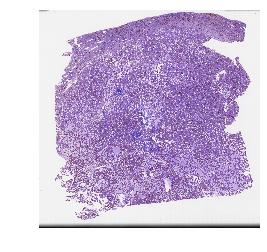

In [15]:
plt.imshow(img)
plt.axis('off')

(-0.5, 2987.5, 2939.5, -0.5)

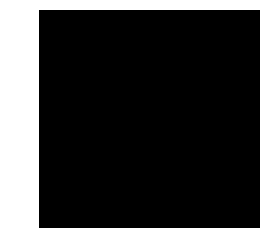

In [16]:
plt.imshow(img_norm)
plt.axis('off')

In [12]:
img_aug = hematoxylin_eosin_aug(img_norm, low=COLOR_LO, high=COLOR_HI)

In [18]:
single_image_crops = get_crops(img_aug, 512, PATCHES_PER_IMAGE)

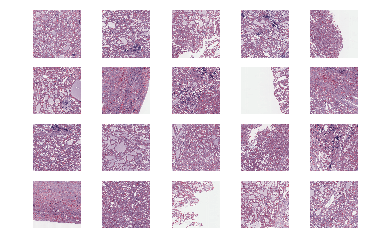

In [19]:
plt.figure()
for i in range(20): 
    plt.subplot(4,5,i + 1)
    plt.imshow(single_image_crops[i])
    plt.axis('off')

In [ ]:
#PCA and SVD on img_norm

In [4]:
img_norm.shape

NameError: name 'img_norm' is not defined